### 분석에 필요한 패키지 Import

In [2]:
!pip install xgboost lightgbm catboost scikit-learn --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [5]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [6]:
df.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  
0                          0           0  
1                          3           1  
2                          2           0  
3                          5           1  
4                          2           1

In [7]:
target = 'LeaveOrNot'

In [8]:
X = df.drop(columns=[target]) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [10]:
X.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  
0                          0  
1                          3  
2                          2  
3                          5  
4                          2

In [11]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [12]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [13]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [15]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [16]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [17]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



#### 2. 의사결정나무

In [18]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [19]:
y_tree_pred = tree.predict(X_test)

In [20]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8359106529209622
Report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.78      0.71      0.74       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



#### 3. SVM

In [21]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [22]:
y_svm_pred = svm.predict(X_test)

In [23]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8548109965635738
Report :
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       775
           1       0.91      0.63      0.74       389

    accuracy                           0.85      1164
   macro avg       0.87      0.80      0.82      1164
weighted avg       0.86      0.85      0.85      1164



#### 4. kNN

In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [25]:
y_knn_pred = knn.predict(X_test)

In [26]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8298969072164949
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       775
           1       0.81      0.64      0.72       389

    accuracy                           0.83      1164
   macro avg       0.82      0.78      0.80      1164
weighted avg       0.83      0.83      0.82      1164



#### 네 가지 단일 모델의 결과 비교

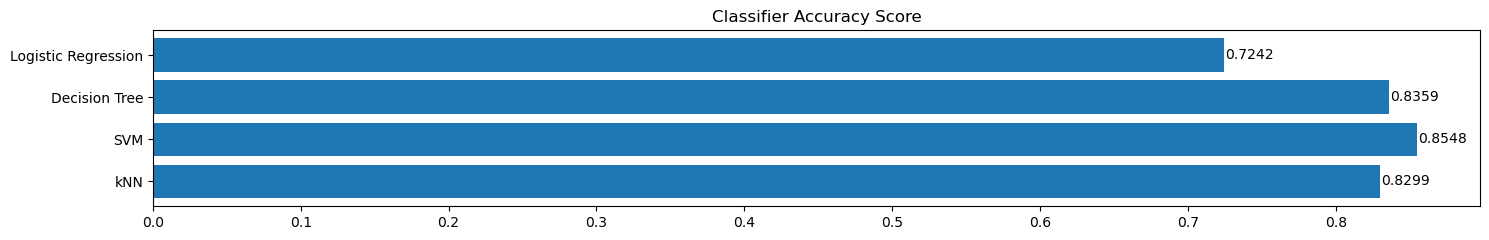

In [27]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [28]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [29]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8505


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [30]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8531


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [31]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8239


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [32]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [33]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)
# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8608


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [34]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8582


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [35]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8634


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [36]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=SEED), # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8557


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

# soft voting (확률 기반 투표)
voting_soft = VotingClassifier(
    estimators=models,
    voting='soft' # 방식만 soft voting 방식으로 변경
)

voting_soft.fit(X_train, y_train)
y_soft_pred = voting_soft.predict(X_test)

print(f"Soft Voting Accuracy: {accuracy_score(y_test, y_soft_pred)}")

Soft Voting Accuracy: 0.8419243986254296


-> 기존 하드 보팅 방식으로 진행했을 때보다 정확도가 더 낮아진 상황 <br>
+ 기존 하드보팅 정확도 : 약 0.8505
+ 현재 소프트보팅 정확도 : 약 0.8419
<br>
### Q. 어떻게 소프트보팅 모델의 성능을 높일 수 있을까?

### [방법 1] Soft Voting + 가중치 조정 적용
 -> RandomForest가 성능이 가장 높을 가능성이 크니, 가중치를 더 줘보겠음

In [38]:
models = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

# soft voting + weight 적용 (RF에 2배 비중)
voting_soft_weighted = VotingClassifier(
    estimators=models,
    voting='soft',
    weights=[1, 1, 2]
)

voting_soft_weighted.fit(X_train, y_train)
y_weighted_pred = voting_soft_weighted.predict(X_test)

from sklearn.metrics import accuracy_score
print(f"Weighted Soft Voting Accuracy: {accuracy_score(y_test, y_weighted_pred)}")

Weighted Soft Voting Accuracy: 0.8513745704467354


### [방법 2] Soft Voting 조합을 더 다양한 모델로 구성
-> 현재 기존 모델은 모두 tree 계열에 가까워 예측 패턴이 유사할 수 있음 <br>
-> 서로 학습 방식이 다른 모델을 조합해야 soft voting시 시너지가 날 수 있음


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

models_diverse = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('cb', CatBoostClassifier(verbose=0, random_state=SEED))
]

voting_diverse = VotingClassifier(
    estimators=models_diverse,
    voting='soft'
)

voting_diverse.fit(X_train, y_train)
y_diverse_pred = voting_diverse.predict(X_test)

print(f"Diverse Soft Voting Accuracy: {accuracy_score(y_test, y_diverse_pred)}")

Diverse Soft Voting Accuracy: 0.8625429553264605


### Soft Voting 성능 개선 시도 요약

+ 기본 Soft Voting : 약 0.8419
+ Hard Voting (기존) : 약 8505
+ Weighted Soft Voting (1,1,2) : 약 0.8514
+ Diverse Soft Voting Models : 약 0.8625
<br>

**분석**:
- 단순 Soft Voting은 Hard Voting보다 성능이 낮았으나,
- **가중치 조정**을 통해 Hard Voting과 비슷한 수준으로 성능 개선됨
- 서로 다른 계열의 모델(KNN, CatBoost 등)을 조합한 **Diverse Soft Voting**이 가장 높은 정확도를 기록함

### [추가시도] Stacking을 단순한 트리 계열 조합 대신 다양한 계열 모델을 이용해 구성해보기

In [42]:
# Base 모델을 다양하게 + 최종 메타 모델을 강력한 부스팅 모델로 시도
from xgboost import XGBClassifier
# Base 모델 구성 (다양한 계열)
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('cb', CatBoostClassifier(verbose=0, random_state=SEED))
]

# 메타 모델 (최종 예측 담당)
meta_model = XGBClassifier(random_state=SEED)

# 스태킹 모델 생성
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 학습 및 예측
stacking_clf.fit(X_train, y_train)
y_stack_pred = stacking_clf.predict(X_test)

# 평가
print("Stacking Accuracy:", accuracy_score(y_test, y_stack_pred))

Stacking Accuracy: 0.8298969072164949


+ 기존에 진행했던 스태킹보다 성능이 낮아짐을 확인 (ㅠㅠ)
+ 메타모델로 선정한 XGBoost의 과적합 가능성을 인지하고 다시 LogisticRegression으로 변경해 재시도

In [ ]:
# Base 모델 구성 (다양한 계열)
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('cb', CatBoostClassifier(verbose=0, random_state=SEED))
]

# 메타 모델 (최종 예측 담당)
meta_model = LogisticRegression(random_state=SEED)

# 스태킹 모델 생성
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 학습 및 예측
stacking_clf.fit(X_train, y_train)
y_stack_pred = stacking_clf.predict(X_test)

# 평가
print("Stacking Accuracy:", accuracy_score(y_test, y_stack_pred))

Stacking Accuracy: 0.872852233676976


### Stacking 모델 성능 비교 요약
+ [Base : Logistic + DecisionTree + RandomForest, Meta : LogisticRegression] 정확도 0.8557
+ [Base : Logistic + KNN + CatBoost, Meta : XGBoost] 정확도 0.8299
+ [Base : Logistic + KNN + CatBoost, Meta : LogisticRegression] 정확도 0.8729
<br>

### 분석

+ **기존 구성**(LR + DT + RF)은 의사결정트리 기반 모델들로 구성되어 해당 데이터셋에 높은 적합도를 보임
+ 다양한 계열(KNN, CatBoost) 조합은 처음엔 성능이 낮았지만, **메타 모델을 XGBoost → LogisticRegression으로 교체**하자 오히려 성능이 0.8729로 상승함 (혼자 하면서 신기방기했음..)
+ 나름대로 해석) XGBoost가 복잡한 판단을 하면서 과적합을 유발했던 반면, **LogisticRegression은 더 단순하고 일반화에 유리**했기 때문임

### [지피티의 추천] base learner 하나씩 튜닝 후 교체해보기

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# 튜닝할 파라미터
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# 그리드 서치 수행
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("Best KNN parameters:", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_

Best KNN parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}


In [44]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist_cb = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

catboost_model = CatBoostClassifier(verbose=0, random_state=SEED)

random_search_cb = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist_cb,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1
)

random_search_cb.fit(X_train, y_train)
print("Best CatBoost params:", random_search_cb.best_params_)
best_cb = random_search_cb.best_estimator_

Best CatBoost params: {'learning_rate': 0.03, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 6}


In [ ]:
# Base 모델 구성
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('knn', best_knn),
    ('cb', best_cb)
]

# 메타 모델 (최종 예측 담당)
meta_model = LogisticRegression(random_state=SEED)

# 스태킹 모델 생성
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 학습 및 예측
stacking_clf.fit(X_train, y_train)
y_stack_pred = stacking_clf.predict(X_test)

# 평가
print("Stacking Accuracy:", accuracy_score(y_test, y_stack_pred))

Stacking Accuracy: 0.8780068728522337


+ KNN과 CatBoost 모델에 대해 GridSearchCV와 RandomizedSearchCV를 이용한 하이퍼파라미터 튜닝 수행  
+ 튜닝된 모델을 base learner로 활용한 결과, 기존 대비 더 높은 성능(약 0.8780)을 확인할 수 있었음 ^^!! (지피티 한건 하심)